## Setup

https://huggingface.co/blog/sentiment-analysis-python

Maybe try some different frameworks for use here


In [61]:
import os
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import string
nltk.download('punkt')

root = os.getcwd()[-0:-7]
root

import torch
torch.cuda.is_available()

run_model = True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lawre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Data

In [62]:
news_arc = pd.read_csv(root+"/data/news_arc.csv")
news_arc.head(5)

,stock,headline,date,sector,dte
0,BHP,"CSat Investment Advisory, L.P. Buys iShares Co...",2020-05-12T00:00:00Z,i,2020-05-12
1,BHP,"Headinvest, Llc Buys Vanguard Short-Term Corpo...",2020-05-11T00:00:00Z,i,2020-05-11
2,BHP,"Toroso Investments, LLC Buys iShares Core S&P ...",2020-05-08T00:00:00Z,i,2020-05-08
3,BHP,"Resource Management, LLC Buys Schwab U.S. ...",2020-05-05T00:00:00Z,i,2020-05-05
4,BHP,Four Dozen Eggs,2020-04-26T00:00:00Z,i,2020-04-26


In [63]:
news_arc.headline.to_list()[0:5]

['CSat Investment Advisory, L.P. Buys iShares Core S&P Total U.S. ...',
 'Headinvest, Llc Buys Vanguard Short-Term Corporate Bond ETF, Vanguard Short-Term Bond, IDEXX ...',
 'Toroso Investments, LLC Buys iShares Core S&P Total U.S. ...',
 'Resource Management, LLC Buys Schwab U.S. ...',
 'Four Dozen Eggs']

In [64]:
news_eod = pd.read_csv(root+"/data/news_eod.csv", index_col = 0)

neu = news_eod["neu"]
pos = news_eod["pos"]
neg = news_eod["neg"]

#Firstly do the sentiment that is over a certain threshold for the 
conditions = [(pos > 0.1),  (neg > 0.1), (neu > 0.5)]
choices  = [1,0,2]
news_eod["lbl"] = np.select(conditions, choices, 2)

#Then do a test to see if one class is bigger than other and 
#give the corresponsing label
conditions = [(pos > neg),  (neg > pos)]
choices  = [1,0]
news_eod["lbl"] = np.select(conditions, choices, news_eod["lbl"])

#Finally if the neutrality is reallyhigh then just label it as neutral
news_eod.loc[news_eod.neu > 0.85, 'lbl'] = 2

#Make combined article for the MLP
news_eod['text'] = news_eod[['title', 'content']].agg(' '.join, axis=1)

print(Counter(news_eod["lbl"]))
news_eod[["dte", "title", "content", "neg", "neu", "pos", "lbl", "text"]]

Counter({2: 10607, 1: 7127, 0: 998})


,dte,title,content,neg,neu,pos,lbl,text
0,2016-04-22,NOTICE: Rosen Law Firm Reminds BHP Billiton Li...,"NEW YORK, April 22, 2016 (GLOBE NEWSWIRE) --...",0.092,0.812,0.096,1,NOTICE: Rosen Law Firm Reminds BHP Billiton Li...
1,2016-04-22,"UPCOMING DEADLINE: Levi & Korsinsky, LLP Remin...","NEW YORK, April 22, 2016 (GLOBE NEWSWIRE) --...",0.100,0.848,0.052,0,"UPCOMING DEADLINE: Levi & Korsinsky, LLP Remin..."
2,2016-04-13,"SHAREHOLDER ALERT: Faruqi & Faruqi, LLP Encour...","NEW YORK, April 13, 2016 (GLOBE NEWSWIRE) --...",0.080,0.818,0.102,1,"SHAREHOLDER ALERT: Faruqi & Faruqi, LLP Encour..."
3,2016-04-06,INVESTOR ALERT: The Law Offices of Vincent Won...,"NEW YORK, April 06, 2016 (GLOBE NEWSWIRE) --...",0.129,0.809,0.061,0,INVESTOR ALERT: The Law Offices of Vincent Won...
4,2016-04-04,EQUITY ALERT: Rosen Law Firm Announces Filing ...,"NEW YORK, April 04, 2016 (GLOBE NEWSWIRE) --...",0.097,0.809,0.094,0,EQUITY ALERT: Rosen Law Firm Announces Filing ...
...,...,...,...,...,...,...,...,...
834,2022-01-07,Valero Energy Stock Shows Rising Relative Stre...,One important metric to look for in a stock is...,0.023,0.698,0.279,1,Valero Energy Stock Shows Rising Relative Stre...
835,2022-01-06,Will Valero Energy (VLO) Beat Estimates Again ...,Looking for a stock that has been consistently...,0.030,0.824,0.146,1,Will Valero Energy (VLO) Beat Estimates Again ...
836,2022-01-06,10 Safe Dividend Stocks with High Yields,"In this article, we will discuss 10 safe divid...",0.019,0.897,0.085,2,10 Safe Dividend Stocks with High Yields In th...
837,2022-01-05,Valero Energy (VLO) Stock Moves -0.39%: What Y...,Valero Energy (VLO) closed at $78.20 in the la...,0.017,0.857,0.126,2,Valero Energy (VLO) Stock Moves -0.39%: What Y...


In [65]:
X = news_eod
X = news_eod.drop('lbl', axis=1)

y = news_eod["lbl"]

from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X, y)

#X_res, y_res = over_sampler.random_undersampler(X, y)
print(f"Training target statistics: {Counter(y_res)}")

Training target statistics: Counter({0: 998, 1: 998, 2: 998})


In [66]:
news_eod.describe()

,polarity,neg,neu,pos,lbl
count,18716.000000,18716.000000,18716.000000,18716.000000,18732.000000
mean,0.717238,0.034642,0.856259,0.109092,1.512972
std,0.534864,0.036569,0.055691,0.052186,0.596998
min,-0.999000,0.000000,0.468000,0.000000,0.000000
25%,0.758000,0.011000,0.827000,0.079000,1.000000
50%,0.991000,0.025000,0.857000,0.107000,2.000000
75%,0.998000,0.047000,0.887000,0.137000,2.000000
max,1.000000,0.468000,1.000000,0.492000,2.000000


In [67]:
eod_ran_samp = news_eod[["date","title","content","sector","company","polarity","neg","pos","neu","lbl"]].groupby('lbl').apply(lambda s: s.sample(2))
eod_ran_samp

date  \
lbl                                  
0   653  2021-08-17T23:00:00+00:00   
    434  2022-09-13T21:24:00+00:00   
1   728  2022-03-26T13:27:00+00:00   
    491  2023-03-07T16:15:04+00:00   
2   130  2021-11-29T07:59:18+00:00   
    14   2021-12-08T12:20:00+00:00   

                                                     title  \
lbl                                                          
0   653       Is This South America’s Last Great Oil Boom?   
    434  Gas Prices Are Lower, but Other Energy Product...   
1   728  U.S. Gasoline Profits Will Stay Pumped Up. Buy...   
    491  TotalEnergies (TTE) to Gain From LNG Focus &am...   
2   130  American Airlines, Halliburton, Moderna Rise P...   
    14        Have You Seen These Cleveland-Cliffs Charts?   

                                                   content sector company  \
lbl                                                                         
0   653  The Guyana-Suriname basin is gaining considera...      c     XOM   
    434  There's less pain at the pump, but other price...      c     VLO   
1   728  Valero, Marathon Petroleum, and Phillips 66 ar...      c     VLO   
    491  TotalEnergies’ TTE diverse assets across the g...      c     CVX   
2   130  By Peter Nurse\n\nInvesting.com -- Stocks in f...      c     CVX   
    14   The newly minted steel company has trounced th...      i     CLF   

         polarity    neg    pos    neu  lbl  
lbl                                          
0   653    -0.988  0.133  0.114  0.752    0  
    434    -0.678  0.227  0.000  0.773    0  
1   728     0.671  0.000  0.234  0.766    1  
    491     0.996  0.043  0.169  0.788    1  
2   130    -0.572  0.040  0.033  0.927    2  
    14      0.226  0.000  0.087  0.913    2

In [68]:
eod_ran_samp.content.to_list()

['The Guyana-Suriname basin is gaining considerable attention from big oil despite the threat of peak oil demand and global push to significantly reduce carbon emissions. The U.S. Geological Survey calculated that the basin had mean undiscovered resources of 15.2 billion barrels of crude oil, 2.3 billion barrels of natural gas liquids and 42 trillion cubic feet of natural gas. Those numbers along with ExxonMobil’s exceptional exploration success in the Stabroek block offshore Guyana, with 21 high-quality oil discoveries, highlight the considerable hydrocarbon potential of what could be the last major offshore oil boom. The considerable potential of the Guyana-Suriname basin saw the USGS commit to reassessing its hydrocarbon potential in late-2019 but that was delayed by the pandemic.\n\nWhile Guyana is at the heart of what is emerging as South America’s hottest offshore oil boom, things continue to heat up on the Suriname side of the oil basin. Apache and partner TotalEnergies are expe

In [69]:
#Train Test Split
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y


def train_val_test_split(df, target_col, test_ratio, shuffle = False):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_ratio, shuffle=shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_ratio, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(pd.concat([X_res, y_res], axis = 1), 'lbl', 0.2, shuffle = True)

from datasets import Dataset
train = Dataset.from_dict(pd.concat([X_train["text"], y_train], axis = 1))
test = Dataset.from_dict(pd.concat([X_test["text"], y_test], axis = 1))
val = Dataset.from_dict(pd.concat([X_val["text"], y_val], axis = 1))

X_train = train['text']
y_train = train['lbl']

X_test = test['text']
y_test = test['lbl']

X_val = val['text']
y_val = val['lbl']

X_val[1]
y_val[1]

2

In [70]:
# from datasets import load_dataset
# imdb = load_dataset("imdb")

In [71]:
# small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
# small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

# small_train_dataset = y_train["lbl"]
# small_test_dataset = y_test["lbl"]
# small_train_dataset

## Visualisation

In [72]:
import nltk
nltk.download('stopwords')
stop_words =nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lawre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

def custom_feature_extraction(text, ngrams=2, compute=0, vectorizer = None, max_df = 1.0, min_df = 0.0, binary = False, 
                              analyzer = 'word', preprocessor = None, stop_words = "english", vec_type = "count"):
    if compute:
    # Extract unigrams, bigrams, and trigrams
      if vec_type == "count":
        vectorizer = CountVectorizer(ngram_range=(1, ngrams), max_df = max_df, min_df = min_df, 
                                     binary = binary, analyzer = analyzer, preprocessor = preprocessor, stop_words = stop_words)
        features = vectorizer.fit_transform(text)
        return features, vectorizer
      elif vec_type == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=(1, ngrams), max_df = max_df, min_df = min_df, 
                                     binary = binary, analyzer = analyzer, preprocessor = preprocessor, stop_words = stop_words)
        features = vectorizer.fit_transform(text)
        return features, vectorizer
    else: 
        features = vectorizer.transform(text) # only applies the text to feature vector
        return features

# Extract features using custom feature extraction function
X_train_feats, feat_extractor = custom_feature_extraction(X_train, compute=1, preprocessor = None, vec_type = "tfidf", stop_words = stop_words)
#X_train_feats, feat_extractor = custom_feature_extraction(X_train, compute=1)
X_val_feats = custom_feature_extraction(X_val, compute=0, vectorizer=feat_extractor, preprocessor = None, vec_type = "tfidf", stop_words = stop_words)
X_test_feats = custom_feature_extraction(X_test, compute=0, vectorizer=feat_extractor, preprocessor = None, vec_type = "tfidf", stop_words = stop_words)

In [74]:
X_train_dt = pd.DataFrame({"twt": X_train, "label": y_train})
X_train_dt.head()

,twt,label
0,Oil Prices Down Despite Libya Outage Have you ...,0
1,3 Steel Producer Stocks to Escape Industry Cha...,1
2,"Fed Meeting, Big Tech's Big Quarter, Mask Warn...",2
3,Are Basic Materials Stocks Lagging Linde PLC ...,1
4,Exxon tops estimates with biggest quarterly pr...,0


In [75]:
X_train[0:5]

["Oil Prices Down Despite Libya Outage Have you already subscribed to the Oilprice.com youtube channel? If not, sign up today to make sure you don't miss out on any of the breaking news and educational videos produced every week.\n\nChart of the Week\n\n- Colder-than-normal temperatures in January and February led to higher natural gas inventory withdrawals.\n\n- Gas storage at the end of heating season (March 31) totaled 1,778 Bcf, or 1.4% less than the five-year average.\n\n- Withdrawals were 10.6% larger than the five-year average.\n\nMarket Movers\n\n- Baker Hughes (NYSE: BKR) was upgraded by BMO to Outperform.\n\n- New Petrobras (NYSE: PBR) CEO pledged price parity for fuel imports and maintaining a focus on deepwater.\n\n- First Solar (NASDAQ: FSLR) was upgraded from Neutral to Buy by Citi on a “catalyst rich environment.”\n\nTuesday Aril 20, 2021\n\nOil prices posted modest gains on early Tuesday morning following reports of an outage in Libya, but demand concerns sent prices fa

In [76]:
import nltk
gen_feats_df = pd.DataFrame({"features": feat_extractor.get_feature_names_out(), "count" :X_train_feats.toarray().sum(axis=0)})
gen_feats_df = gen_feats_df.sort_values(by=["count"], ascending=False)
gen_feats_df.head(20)

,features,count
357473,zacks,54.688042
226955,oil,40.385624
309604,steel,36.600634
117728,earnings,36.411875
311076,stock,36.388499
85342,company,36.280260
311959,stocks,35.022319
354840,year,34.509846
122808,energy,31.354475
224507,nyse,27.560973


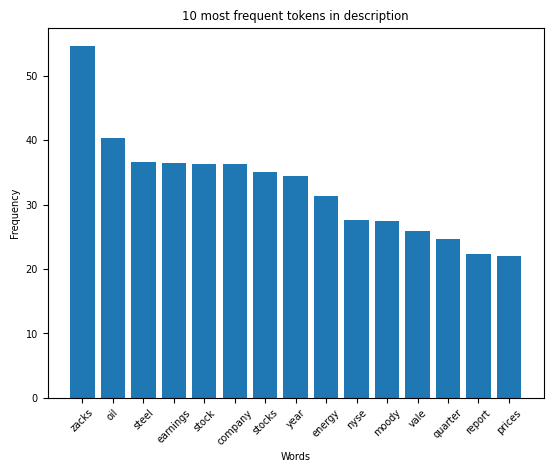

In [77]:
plt.bar(gen_feats_df.head(15)['features'], gen_feats_df.head(15)['count'])
plt.xticks(rotation = 45)
plt.title("10 most frequent tokens in description")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.savefig("wordfrequency.png")
plt.show()

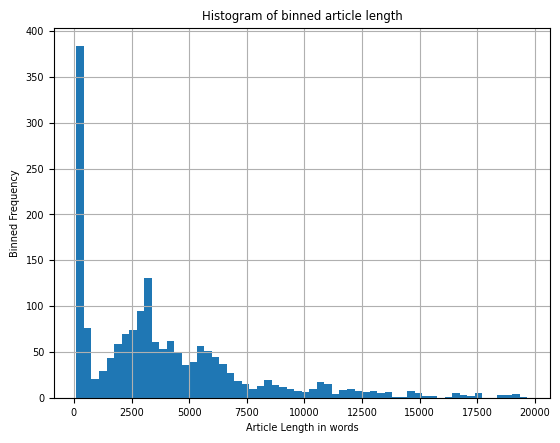

In [78]:
X_train_dt.twt.str.len().where(X_train_dt.twt.str.len() < 20000).hist(bins = 60)
plt.title("Histogram of binned article length")
plt.ylabel("Binned Frequency")
plt.xlabel("Article Length in words")
plt.savefig("articlelength.png")
plt.show()

In [79]:
X_train_dt.twt.str.len().where(X_train_dt.twt.str.len() > 20000).sort_values(ascending = False)[0:20]

1387    45575.0
1624    43877.0
1316    42531.0
1718    39276.0
305     30682.0
1231    29272.0
772     28384.0
941     27779.0
1591    27616.0
1256    25573.0
583     25143.0
755     25088.0
838     24815.0
18      24744.0
573     24682.0
904     24622.0
399     24622.0
1021    23848.0
1287    23733.0
506     23597.0
Name: twt, dtype: float64

In [80]:
X_train_dt.twt.str.len().median()

3175.0

In [81]:
X_train_dt.twt[502]

'The Zacks Rank Explained: How to Find Strong Buy Oils and Energy Stocks Whether you\'re a growth, value, income, or momentum-focused investor, building a successful investment portfolio takes skill, research, and a little bit of luck.\n\nHow do you find the right combination of stocks that will generate returns that could fund your retirement, or your kids\' college tuition, or your short- and long-term savings goals?\n\nEnter the Zacks Rank.\n\nWhat is the Zacks Rank?\n\nThe Zacks Rank, which is a unique, proprietary stock-rating model, employs earnings estimate revisions, or changes to a company\'s earnings expectations, that makes building a winning portfolio easier.\n\nThere are four main factors behind the Zacks Rank: Agreement, Magnitude, Upside, and Surprise.\n\nAgreement is the extent to which all brokerage analysts are revising their earnings estimates in the same direction. The greater the percentage of analysts revising their estimates higher, the better chance the stock wi

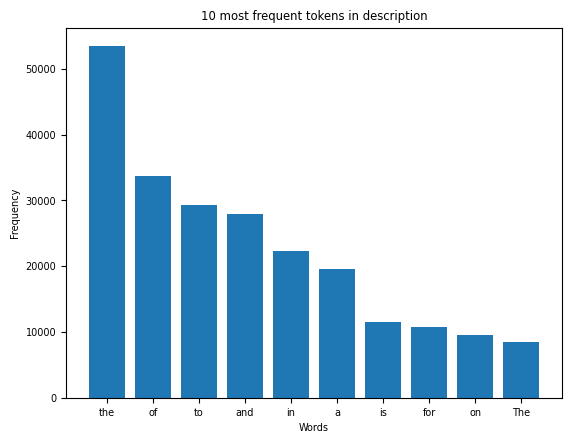

In [82]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

description_list = X_train_dt.twt.values.tolist()

# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(" ".join(description_list).split()).most_common(10)

# `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]

plt.bar(words, counts)
plt.title("10 most frequent tokens in description")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()

In [83]:
X_train_list = word_tokenize(' '.join(X_train))

X_train_list_one = ' '.join(X_train_list)

stop = set(stopwords.words('english') + list(string.punctuation + '’'+ '\`\`' + "\'s"))
X_train_list_imp = [i for i in word_tokenize(X_train_list_one.lower()) if i not in stop]

gen_list_count_imp = pd.DataFrame.from_dict(Counter(X_train_list_imp), orient = "index", columns = ["freq"]) 
gen_list_count_imp = gen_list_count_imp.sort_values(by=["freq"], ascending=False)
gen_list_count_imp.head(20)

,freq
's,6971
company,6383
stock,4724
stocks,4375
nyse,4002
``,3947
oil,3879
earnings,3662
zacks,3653
moody,3648


In [84]:
gen_list_count = pd.DataFrame.from_dict(Counter(X_train_list), orient = "index", columns = ["freq"]) 
gen_list_count = gen_list_count.sort_values(by=["freq"], ascending=False)
gen_list_count.head(10)

,freq
",",62451
the,53729
.,47310
of,33882
to,29370
and,28157
in,22525
a,19767
),17907
(,17866


In [85]:
print(gen_list_count.shape)
print(gen_list_count.freq.sum())

(46347, 1)
1450052


In [86]:
import nltk
nltk.download('stopwords')
stop_words =nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lawre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


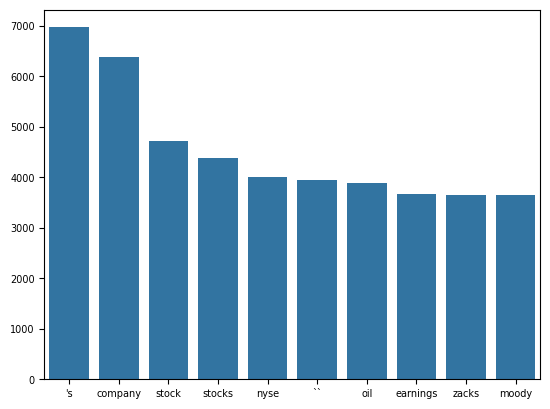

In [87]:
import seaborn as sns
from collections import Counter

X_train_list_one_imp = ' '.join(X_train_list_imp)

word_freq = Counter(X_train_list_one_imp.split())
common_words = word_freq.most_common(10)

sns.barplot(x=[word[0] for word in common_words], y=[word[1] for word in common_words])
plt.show()

In [88]:
# import basic libraries  
import pandas as pd  
import numpy as np  
import re  
import nltk  
from nltk.corpus import stopwords  
from nltk.stem.porter import *  
stemmer = PorterStemmer()  
  
# function to clean text  
def review_to_words(raw_review):  
	# 1. Remove non-letters   
	letters_only = re.sub("[^a-zA-Z]", " ", raw_review)   
	#  
	# 2. Convert to lower case, split into individual words  
	words = letters_only.lower().split()  
	#  
	# 3. Remove Stopwords. In Python, searching a set is much faster than searching  
	# a list, so convert the stop words to a set  
	stops = set(stopwords.words("english"))   
	#   
	# 4. Remove stop words  
	meaningful_words = [w for w in words if not w in stops] #returns a list   
	#  
	# 5. Stem words. Need to define porter stemmer above  
	singles = [stemmer.stem(word) for word in meaningful_words]  
	# 6. Join the words back into one string separated by space,   
	# and return the result.  
	return( " ".join( singles ))   
  
# apply it to our text data   
# dataset is named wine_data and the text are in the column "wmn"  
processed_wmn = [ review_to_words(text) for text in X_train]  

In [89]:
# build a corpus for the word2vec model  
def build_corpus(data):  
    "Creates a list of lists containing words from each sentence"  
    corpus = []  
    for sentence in data:  
        word_list = sentence.split(" ")  
        corpus.append(word_list)   
    
    return corpus  
  
corpus = build_corpus(processed_wmn) 
corpus[0][0:5]

['oil', 'price', 'despit', 'libya', 'outag']

In [90]:
# load the word2vec algorithm from the gensim library  
from gensim.models import word2vec  
# run the model  
model = word2vec.Word2Vec(corpus, vector_size=100, window=5, min_count=1000, workers=4)  
[x for x in model.wv.index_to_key][0:5]  

['stock', 'compani', 'rate', 'year', 'price']

In [91]:

word_all = pd.DataFrame(columns = ["word", "related", "distance"])

for x in model.wv.index_to_key[0:15]:
    #print(x)

    related = pd.DataFrame(data = [(item[0],round(item[1],2)) for item in model.wv.most_similar(x)], columns = ["related", "distance"])
    
    comb = related.assign(word = np.resize(x, len(related)))

    word_all = pd.concat([word_all, comb])
    
#pd.DataFrame(data = k)
word_all_piv = word_all.pivot(index = "related", columns = "word", values = "distance")#.fillna(value = 0)
word_all_top = word_all.groupby("related").count().query('word > 2').sort_values("word", ascending=False)
word_all_piv.filter(word_all_top.index, axis = 0).fillna("-")

word,compani,earn,energi,investor,market,moodi,nyse,oil,price,rate,report,share,stock,year,zack
related,,,,,,,,,,,,,,,
consensu,-,0.78,-,-,-,-,-,-,0.39,-,0.36,0.35,-,0.61,0.5
per,-,0.58,-,-,-,-,-,-,0.38,-,0.38,0.64,-,0.65,-
chevron,-,-,0.61,-,-,-,0.46,0.57,-,-,-,-,-,-,-
credit,-,-,-,0.43,-,0.88,-,-,-,0.79,-,-,-,-,-
day,-,0.53,-,-,-,-,-,-,-,-,0.57,-,-,0.61,-
earn,-,-,-,-,-,-,-,-,-,-,0.43,0.45,-,-,0.56
energi,0.41,-,-,-,-,-,0.47,0.74,-,-,-,-,-,-,-
estim,-,0.83,-,-,-,-,-,-,-,-,-,0.35,-,-,0.55
global,-,-,0.53,-,0.4,-,-,0.5,-,-,-,-,-,-,-


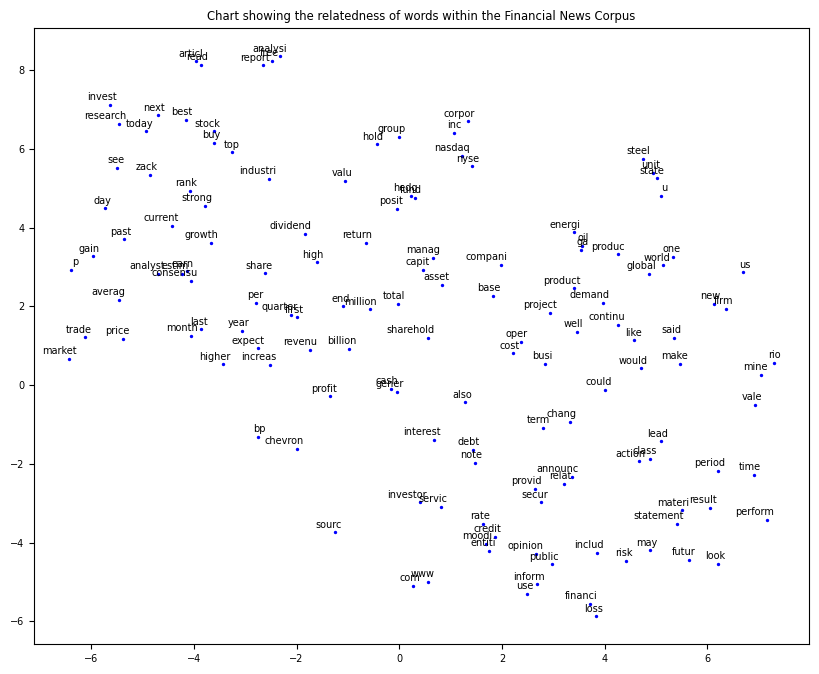

In [92]:
# import the t-SNE library and matplotlib for plotting  
from sklearn.manifold import TSNE  
import matplotlib.pyplot as plt  
  
# define the function to compute the dimensionality reduction  
# and then produce the biplot  
#def tsne_plot(model):  
#"Creates a TSNE model and plots it"  
labels = []  
tokens = []  

for word in model.wv.index_to_key: 
    #print(word)
    tokens.append(model.wv.get_vector(word, norm=True))  
    labels.append(word)  
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)  
new_values = tsne_model.fit_transform(np.vstack(tokens))

x = []  
y = []  
for value in new_values:  
    x.append(value[0])  
    y.append(value[1])  

plt.figure(figsize=(10, 8))   
for i in range(len(x)):  
    plt.scatter(x[i],y[i],
                c="blue",
                   s=2)  
    plt.annotate(labels[i],  
                    xy=(x[i], y[i]),  
                    xytext=(5, 2),  
                    textcoords='offset points',  
                    ha='right',  
                    va='bottom')  

plt.rcParams.update({'font.size': 7})
plt.title("Chart showing the relatedness of words within the Financial News Corpus")
plt.savefig("wordrelatedness.png")
plt.show()  

# call the function on our dataset  
#tsne_plot(model)  

In [93]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# import numpy as np

# # Example: Creating a small corpus
# corpus = X_train

# # Tokenize and vectorize the corpus
# vectorizer = CountVectorizer()
# X = vectorizer.fit_transform(corpus)

# # Apply Latent Dirichlet Allocation (LDA) to get word embeddings
# lda = LatentDirichletAllocation(n_components=2, random_state=42)
# word_embeddings = lda.fit_transform(X)

# # Apply t-SNE for dimensionality reduction
# tsne = TSNE(n_components=2, random_state=42)
# word_embeddings_2d = tsne.fit_transform(word_embeddings)

# # Visualize the result
# plt.figure(figsize=(10, 8))
# plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], marker='o')

# for i, txt in enumerate(vectorizer.get_feature_names_out()):
#     plt.annotate(txt, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

# plt.title("t-SNE Visualization of Word Embeddings")
# plt.show()


## End-to-End Model

In [94]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [95]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)
 
tokenized_train = train.map(preprocess_function) # , batched=True
tokenized_test = test.map(preprocess_function) # , batched=True


Map: 100%|██████████| 449/449 [00:00<00:00, 488.49 examples/s]


In [96]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [97]:
from transformers import AutoModelForSequenceClassification
#model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

id2label = {0: "negative", 1: "positive", 2: "neutral"}
label2id = {"negative": 0, "positive": 1, "neutral" : 2}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.we

In [98]:
import numpy as np
from datasets import load_metric
 
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels, average = "weighted")["f1"]
   return {"accuracy": accuracy, "f1": f1}

In [99]:
from transformers import TrainingArguments, Trainer
 
repo_name = "finetuning-sentiment-model-3000-samples"
 
training_args = TrainingArguments(
   output_dir="transformer/fin_news",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=False,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train.rename_column("lbl", "label"),
   eval_dataset=tokenized_test.rename_column("lbl", "label"),
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
tokenized_train

Dataset({
    features: ['text', 'lbl', 'input_ids', 'attention_mask'],
    num_rows: 1796
})

 https://stackoverflow.com/questions/72367324/calculate-precision-recall-f1-score-for-custom-dataset-for-multiclass-classifi

In [100]:
if run_model:
    trainer.train()
    eval_results = trainer.evaluate()
    
    import math
    print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")
    print(eval_results)

C:\Users\lawre\anaconda3\envs\nlp\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


C:\Users\lawre\AppData\Local\Temp\ipykernel_15108\3927253779.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


Perplexity: 2.20
{'eval_loss': 0.7889893651008606, 'eval_accuracy': 0.6503340757238307, 'eval_f1': 0.6458570017861139, 'eval_runtime': 500.0162, 'eval_samples_per_second': 0.898, 'eval_steps_per_second': 0.058, 'epoch': 3.0}


In [101]:
from transformers import pipeline
from tensorflow.python.keras.engine.base_layer_utils import call_context
classifier = pipeline("sentiment-analysis", model= root + "/Python/transformer/fin_news/checkpoint-226")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [102]:
news_arc['sentiment_ctr'] = news_arc.apply(lambda row: classifier(row['headline'])[0]['label'], axis=1)
news_arc['sentiment_probability_ctr'] = news_arc.apply(lambda row: classifier(row['headline'])[0]['score'], axis=1)

news_arc[['dte','sentiment_ctr']].pivot_table(index="sentiment_ctr", aggfunc='count')

,dte
sentiment_ctr,
negative,6541
neutral,7638
positive,431


In [103]:
news_arc.to_csv(root + "/data/news_arc_sentiment.csv")
news_eod.to_csv(root + "/data/news_eod_sentiment.csv")

## End to end model